## Data Challenge 4: Redcard Prediction

#### Brian Henn and Rachel Millin, Insight Data Science, July 26, 2018

#####  “Are soccer referees more likely to give red cards to dark skin toned players than light skin toned players?” 

##### The dataset came from the players who played in the 2012–13 European football (soccer) professional leagues. Data about the players’ ages, heights, weights, position, skintone rating, and more were included. Explore the data and try to answer the posed question.

Some ideas before looking at the data to explore here:

-Could we build a multivariate linear model that estimates the relationship between skin tone and red cards, as well as the relationship between red cards and other factors that are not skin tone (to limit confounding variables such as the league where the player plays, the player's weight/height/position, etc.)? 

In [1]:
# import stuff

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler


#### For reference, here is the dataset's column metadata:

\b playerShort 
\b0 - short player ID\

\b player 
\b0 - player name\

\b club
\b0  - player club\

\b leagueCountry
\b0  - country of player club (England, Germany, France, and Spain)\

\b birthday
\b0  - player birthday\

\b height
\b0  - player height (in cm)\

\b weight
\b0  - player weight (in kg)\

\b position
\b0  - detailed player position \

\b games
\b0  - number of games in the player-referee dyad\

\b victories
\b0  - victories in the player-referee dyad\

\b ties
\b0  - ties in the player-referee dyad\

\b defeats
\b0  - losses in the player-referee dyad\

\b goals
\b0  - goals scored by a player in the player-referee dyad\

\b yellowCards
\b0  - number of yellow cards player received from referee\

\b yellowReds
\b0  - number of yellow-red cards player received from referee\

\b redCards
\b0  - number of red cards player received from referee\

\b photoID
\b0  - ID of player photo (if available)\

\b rater1
\b0  - skin rating of photo by rater 1 (5-point scale ranging from \'93very light skin\'94 to \'93very dark skin\'94)\

\b rater2
\b0  - skin rating of photo by rater 2 (5-point scale ranging from \'93very light skin\'94 to \'93very dark skin\'94)\

\b refNum
\b0  - unique referee ID number (referee name removed for anonymizing purposes)\

\b refCountry
\b0  - unique referee country ID number (country name removed for anonymizing purposes)\

\b meanIAT
\b0  - mean implicit bias score (using the race IAT) for referee country, higher values correspond to faster white | good, black | bad associations \

\b nIAT
\b0  - sample size for race IAT in that particular country\

\b seIAT
\b0  - standard error for mean estimate of race IAT       \

\b meanExp
\b0  - mean explicit bias score (using a racial thermometer task) for referee country, higher values correspond to greater feelings of warmth toward whites versus blacks\

\b nExp
\b0  - sample size for explicit bias in that particular country\

\b seExp
\b0  - standard error for mean estimate of explicit bias measure\


In [2]:
# establish the filepath of the data

redcards_filename = './redcard.csv'

In [3]:
# load into a pandas dataframe and have a look

redcards_df = pd.read_csv(redcards_filename)
redcards_df.head()
#print(redcards_df.head())

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
2,abdon-prats,Abdón Prats,RCD Mallorca,Spain,17.12.1992,181.0,79.0,NaN,1,0,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
3,pablo-mari,Pablo Marí,RCD Mallorca,Spain,31.08.1993,191.0,87.0,Center Back,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002
4,ruben-pena,Rubén Peña,Real Valladolid,Spain,18.07.1991,172.0,70.0,Right Midfielder,1,1,...,NaN,3,3,ESP,0.369894,1785.0,0.000229,0.588297,1897.0,0.001002


In [4]:
# it seems like there may be many missing values in this dataset - let's check

len_total = len(redcards_df)

# try including only totally clean rows

nans = pd.isnull(redcards_df)
clean_rows = nans.sum(1) == 0
print(sum(clean_rows),len_total)

115457 146028


In [5]:
redcards_df['club'].unique().shape

(118,)

#### Looks like we lose about 20% of the data this way -- maybe that's OK? Would be easier to proceed with a nan-free dataset, so let's try this approach. Proceeding to exploratory data analysis...

#### First treat each player-ref pairing separately

(115457, 28)


,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,...,rater2,refNum,refCountry,Alpha_3,meanIAT,nIAT,seIAT,meanExp,nExp,seExp
0,lucas-wilchez,Lucas Wilchez,Real Zaragoza,Spain,31.08.1983,177.0,72.0,Attacking Midfielder,1,0,...,0.50,1,1,GRC,0.326391,712.0,0.000564,0.396000,750.0,0.002696
1,john-utaka,John Utaka,Montpellier HSC,France,08.01.1982,179.0,82.0,Right Winger,1,0,...,0.75,2,2,ZMB,0.203375,40.0,0.010875,-0.204082,49.0,0.061504
5,aaron-hughes,Aaron Hughes,Fulham FC,England,08.11.1979,182.0,71.0,Center Back,1,0,...,0.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
6,aleksandar-kolarov,Aleksandar Kolarov,Manchester City,England,10.11.1985,187.0,80.0,Left Fullback,1,1,...,0.25,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752
7,alexander-tettey,Alexander Tettey,Norwich City,England,04.04.1986,180.0,68.0,Defensive Midfielder,1,0,...,1.00,4,4,LUX,0.325185,127.0,0.003297,0.538462,130.0,0.013752


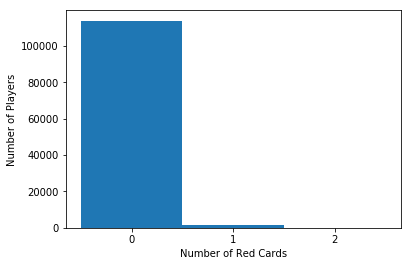

In [6]:
redcards_df = redcards_df.loc[clean_rows,:]
print(redcards_df.shape)

# let's look at the distribution of red card counts
ax = redcards_df['redCards'].plot.hist(bins=[-0.5, 0.5, 1.5, 2.5])
ax.set_xlabel('Number of Red Cards')
ax.set_ylabel('Number of Players')
ax.set_xticks([0,1,2])
redcards_df.groupby(['redCards'])['redCards'].count()

redcards_df.head()


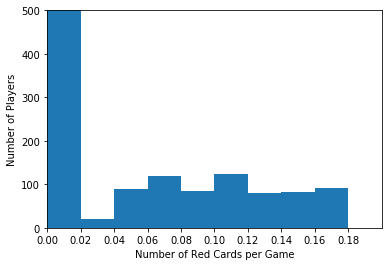

In [7]:
# normalize the number of red cards per game played

redcards_df['redCardsPerGame'] = redcards_df['redCards']/redcards_df['games']

bins = np.arange(0,0.2,0.02)
ax = redcards_df['redCardsPerGame'].plot.hist(bins)
ax.set_xlabel('Number of Red Cards per Game')
ax.set_ylabel('Number of Players')
ax.set_xticks([0,1,2])
ax.set_xlim([0,0.2])
ax.set_ylim([0,500])
ax.set_xticks(bins)
#redcards_df.groupby(['redCards'])['redCards'].count()

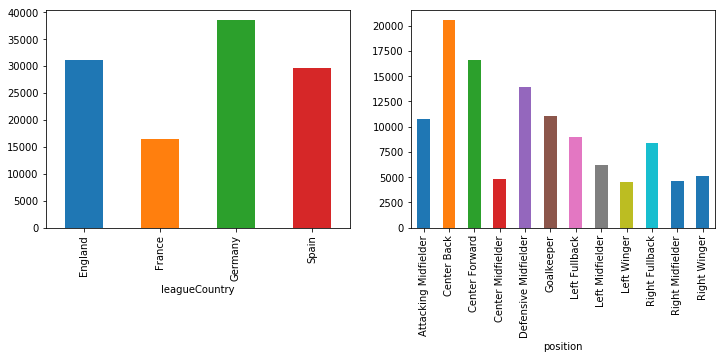

In [8]:
# let's look at the distribution of players in leagues and by position

fig, axs = plt.subplots(1,2)
fig.set_size_inches([12,4])

num_countries = redcards_df.groupby(['leagueCountry'])['leagueCountry'].count()
ax = num_countries.plot.bar(ax = axs[0])

num_positions = redcards_df.groupby(['position'])['position'].count()
num_positions.plot.bar()


OK, so we can see that there are a diversity of leagues and positions, and that these are not evenly distributed. Something to keep in mind.

Let's look at the distribution of skin tone ratings in the dataset.

Text(0,0.5,'Number of Players')

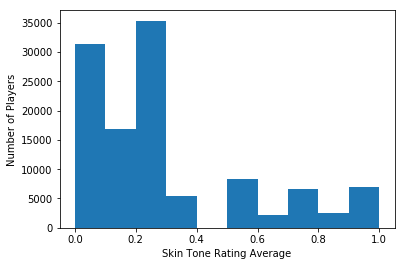

In [9]:
# Start by averaging the two skin tone ratings into one value for simplicity, and plotting distribution

ax = redcards_df['rater_ave'] = redcards_df[['rater1','rater2']].mean(1).plot.hist(bins=10)
ax.set_xlabel('Skin Tone Rating Average')
ax.set_ylabel('Number of Players')

### Let's try fitting the multivariate linear model to a set of potential predictors

This includes player age, position, weight, league, number of games

In [10]:
# Look at distribution of red cards per game within "light" and "dark" skin tone groups

redcards_df['skin-tone average'] = redcards_df[['rater1','rater2']].mean(1)
redcards_df['skin-tone category'] = redcards_df['skin-tone average']>0.5

print(redcards_df['player'].unique().shape)
print(redcards_df.shape)

# start with Mann-Whitney U test to compare average # red cards per game between groups? 

(1406,)
(115457, 32)


In [16]:
# Since there are very few occurrences of more than 1 red card per game, change this to a
# binary prediction - what factors are predictive of getting a red card?

# binarize league, position, ref country, red card given
league_country = np.array(pd.get_dummies(redcards_df.loc[:,'leagueCountry']))
ref_country = np.array(pd.get_dummies(redcards_df.loc[:,'refCountry']))
position = np.array(pd.get_dummies(redcards_df.loc[:,'position']))

redcard = np.array(redcards_df['redCards']>0)

# normalize other features
skin_tone = StandardScaler().fit_transform(np.array(redcards_df['skin-tone average']).reshape(-1, 1)) # leave as is since already goes from 0 to 1
weight = StandardScaler().fit_transform(np.array(redcards_df.loc[:,'weight']).reshape(-1, 1))
height = StandardScaler().fit_transform(np.array(redcards_df.loc[:,'height']).reshape(-1, 1))
n_games = StandardScaler().fit_transform(np.array(redcards_df.loc[:,'games']).reshape(-1, 1))

print(league_country.shape)
print(ref_country.shape)
print(position.shape)
print(skin_tone.shape)
print(weight.shape)
print(height.shape)
print(n_games.shape)

#redcard_features = pd.concat([pd.DataFrame(skin_tone), pd.DataFrame(position), pd.DataFrame(league_country), pd.DataFrame(ref_country), pd.DataFrame(weight), pd.DataFrame(height), pd.DataFrame(n_games)], axis=1)
redcard_features = pd.concat([pd.DataFrame(skin_tone), pd.DataFrame(position), pd.DataFrame(league_country), pd.DataFrame(weight), pd.DataFrame(height), pd.DataFrame(n_games)], axis=1)
print(redcard_features.shape)

redcard_features.head()
print(np.mean(redcard))
print(redcard.shape)


(115457, 4)
(115457, 152)
(115457, 12)
(115457, 1)
(115457, 1)
(115457, 1)
(115457, 1)
(115457, 20)
0.012602094286184466
(115457,)


/Applications/anaconda/envs/insight/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:

# do we want to cross-validate the model?
mdl = linear_model.LogisticRegression(class_weight='balanced').fit(redcard_features, redcard)
print(mdl.score(redcard_features, redcard))
print(mdl.coef_)



0.7855478663052046
[[ 0.09173464 -0.44312108  0.52635103 -0.08873089  0.01165047  0.09362759
   0.16064142  0.17302243 -0.05644432 -0.37764116  0.00083926 -0.38175225
   0.09181618 -0.24142535  0.13980908 -0.30168681  0.11356175  0.10154314
  -0.08961327  0.71779682]]


In [18]:
# run the same model without skin tone to see how it compares

redcard_features = pd.concat([pd.DataFrame(position), pd.DataFrame(league_country), pd.DataFrame(weight), pd.DataFrame(height), pd.DataFrame(n_games)], axis=1)
mdl2 = linear_model.LogisticRegression(class_weight='balanced').fit(redcard_features, redcard)
print(mdl2.score(redcard_features, redcard))
print(mdl2.coef_)


0.7876438847363088
[[-0.46548022  0.5179696  -0.06312536 -0.0158187   0.10733297  0.11704066
   0.1797562  -0.04645076 -0.3584603   0.0046354  -0.38693315  0.12732912
  -0.22780459  0.17127258 -0.32520957  0.09953705  0.11268442 -0.09609977
   0.71443389]]


In [19]:
# run the same model but keep skin type and remove position

redcard_features = pd.concat([pd.DataFrame(skin_tone), pd.DataFrame(league_country), pd.DataFrame(weight), pd.DataFrame(height), pd.DataFrame(n_games)], axis=1)
mdl3 = linear_model.LogisticRegression(class_weight='balanced').fit(redcard_features, redcard)
print(mdl3.score(redcard_features, redcard))
print(mdl3.coef_)


0.7984184588201668
[[ 0.08905198 -0.22223935  0.18574033 -0.33474167  0.15474806  0.1295363
   0.01782133  0.71882217]]


In [20]:
# remove number of games

redcard_features = pd.concat([pd.DataFrame(position), pd.DataFrame(league_country), pd.DataFrame(weight), pd.DataFrame(height)], axis=1)
mdl2 = linear_model.LogisticRegression(class_weight='balanced').fit(redcard_features, redcard)
print(mdl2.score(redcard_features, redcard))
print(mdl2.coef_)


0.5471647453164381
[[-0.45231353  0.57058449 -0.07102035  0.09972878  0.11565838  0.10984274
   0.12311635  0.00578064 -0.30834565  0.02860531 -0.30233735  0.01484835
  -0.08253093  0.24649425 -0.42321015  0.19339498  0.11481842 -0.08869883]]


Removing skin tone from the model doesn't affect the fit.

Combine stats for each player across all occurrences (ignoring who the ref is, since for
now we are only checking whether a bias exists (not who is responsible for it)

Text(0,0.5,'Number of Players')

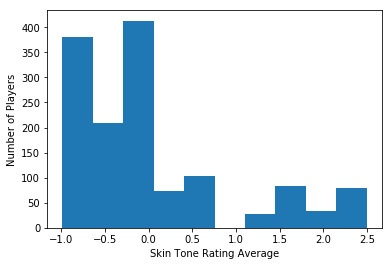

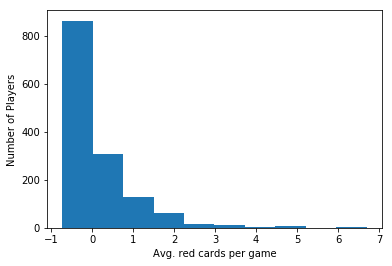

In [51]:
# for each column, group by player
league_country = redcards_df.loc[:,['player', 'leagueCountry']].groupby('player').agg(lambda x:x.value_counts().index[0])
position = redcards_df.loc[:,['player', 'position']].groupby('player').agg(lambda x:x.value_counts().index[0])

redcard = redcards_df.loc[:,['player', 'redCards']].groupby('player').sum().loc[:,'redCards'].astype(float)/ \
    redcards_df.loc[:,['player', 'games']].groupby('player').sum().loc[:,'games'].astype(float) # mean for that player across all matches

skin_tone = redcards_df.loc[:,['player', 'skin-tone average']].groupby('player').mean()
weight = redcards_df.loc[:,['player', 'weight']].groupby('player').mean()
height = redcards_df.loc[:,['player', 'height']].groupby('player').mean()


# binarize features

league_country = np.array(pd.get_dummies(league_country))
position = np.array(pd.get_dummies(position))

# normalize other features
skin_tone = StandardScaler().fit_transform(np.array(skin_tone).reshape(-1, 1)) # leave as is since already goes from 0 to 1
weight = StandardScaler().fit_transform(np.array(weight).reshape(-1, 1))
height = StandardScaler().fit_transform(np.array(height).reshape(-1, 1))

redcard = StandardScaler().fit_transform(np.array(redcard).reshape(-1, 1))

plt.figure()
plt.hist(skin_tone, bins=10)
plt.xlabel('Skin Tone Rating Average')
plt.ylabel('Number of Players')

plt.figure()
plt.hist(redcard, bins=10)
plt.xlabel('Avg. red cards per game')
plt.ylabel('Number of Players')


In [52]:
redcard_features = pd.concat([pd.DataFrame(skin_tone), pd.DataFrame(position), pd.DataFrame(league_country), pd.DataFrame(weight), pd.DataFrame(height)], axis=1)
mdl4 = linear_model.LinearRegression().fit(redcard_features, redcard)
print(mdl4.score(redcard_features, redcard))
print(mdl4.coef_)

# redcard_features.head()


0.07875809164367276
[[ 0.05871301 -0.23326441  0.5350876  -0.08723534 -0.02270799  0.04091947
   0.25804715  0.17046286  0.01536097 -0.32626579 -0.03085068 -0.26553604
  -0.0540178  -0.1260264   0.09483921 -0.1174515   0.14863868  0.02729822
  -0.06100716]]


Text(0,0.5,'Red Cards Per Game')

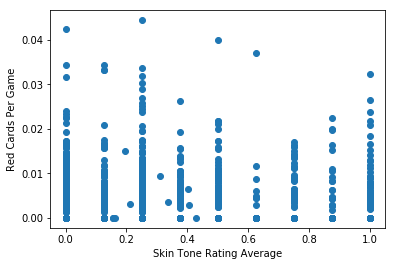

In [54]:
# correlation between skin tone and red cards per game
skin_tone = redcards_df.loc[:,['player', 'skin-tone average']].groupby('player').mean()
redcard = redcards_df.loc[:,['player', 'redCards']].groupby('player').sum().loc[:,'redCards'].astype(float)/ \
    redcards_df.loc[:,['player', 'games']].groupby('player').sum().loc[:,'games'].astype(float) # mean for that player across all matches

plt.figure()
plt.plot(skin_tone, redcard,'o')
plt.xlabel('Skin Tone Rating Average')
plt.ylabel('Red Cards Per Game')


/Applications/anaconda/envs/insight/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


{'whiskers': [<matplotlib.lines.Line2D at 0x1a0fb182e8>,
 'caps': [<matplotlib.lines.Line2D at 0x1a0fb18be0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1a0fb487b8>,
 'medians': [<matplotlib.lines.Line2D at 0x1a0fb309e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a0fb30b00>,
 'means': []}

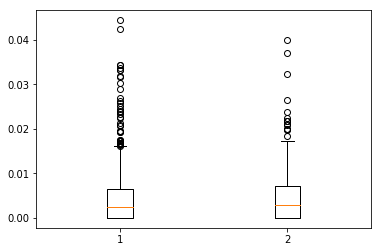

In [60]:
# Look at distribution of other variables (country, weight, height, position) 
# within "light" and "dark" skin tone groups

tone1 = skin_tone<=0.4
tone2 = skin_tone>0.4

plt.figure
plt.boxplot([redcard[tone1['skin-tone average']], redcard[tone2['skin-tone average']]])



In [ ]:
# reduce to just the stats we care about

red_cards_unique_players = redcards_df['player','club','leagueCountry','height','weight','position']
# when collapsing across players, take the average for numeric values and the most frequent for other values


In [23]:
redcards_df['games'].unique()

array([ 1,  2,  5,  4,  3,  6,  8,  9, 10,  7, 11, 12, 26, 14, 16, 35, 19,
       17, 15, 33, 38, 24, 28, 23, 13, 25, 30, 18, 21, 20, 29, 22, 34, 37,
       39, 27, 32, 31, 46, 47, 44, 42, 36, 41, 40])

In [ ]:
# or look at it by ref?
# For each ref, # of redcards to players 